In [1]:
#  STEP 1: Load Dataset

import kagglehub
import os
import tensorflow as tf
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)
data_dir = '/kaggle/input/animals10/raw-img'
print("Classes found in downloaded data directory:", os.listdir(data_dir))

#  Define missing variable
raw_images_path = data_dir


Path to dataset files: /kaggle/input/animals10
Classes found in downloaded data directory: ['cavallo', 'pecora', 'elefante', 'gatto', 'scoiattolo', 'gallina', 'ragno', 'mucca', 'cane', 'farfalla']


In [2]:
#  STEP 2: Load with TensorFlow

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#  Fix: Access class names BEFORE prefetch
class_names = train_ds.class_names
print(" Datasets loaded. Class names:", class_names)

# Apply prefetch AFTER storing class_names
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
 Datasets loaded. Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [3]:
#  STEP 3: Model Definitions (ZFNet, VGG16, GoogLeNet)

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import Sequential

# --- ZFNet ---
def build_zfnet(input_shape=(224, 224, 3), num_classes=10):
    model = Sequential()
    model.add(layers.Conv2D(96, (7, 7), strides=2, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (5, 5), strides=2, activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# --- VGG16 ---
def build_vgg16(input_shape=(224, 224, 3), num_classes=10):
    model = Sequential()
    for filters in [64, 128, 256, 512, 512]:
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=input_shape if filters==64 else None))
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        if filters >= 256:
            model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# --- GoogLeNet (Inception v1) ---
def inception_module(x, f1, f3_in, f3_out, f5_in, f5_out, pool_proj):
    path1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3_out, (3,3), padding='same', activation='relu')(path2)
    path3 = layers.Conv2D(f5_in, (1,1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5_out, (5,5), padding='same', activation='relu')(path3)
    path4 = layers.MaxPooling2D((3,3), strides=1, padding='same')(x)
    path4 = layers.Conv2D(pool_proj, (1,1), padding='same', activation='relu')(path4)
    return layers.concatenate([path1, path2, path3, path4], axis=-1)


def build_googlenet(input_shape=(224,224,3), num_classes=10):
    input_layer = Input(shape=input_shape)
    x = layers.Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = layers.Conv2D(64, (1,1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    return Model(input_layer, output_layer)


In [4]:
#  STEP 4: Train + Evaluate All Models

import time
import matplotlib.pyplot as plt

def train_and_evaluate(model, name):
    model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    history = model.fit(train_ds, validation_data=val_ds, epochs=10)
    duration = time.time() - start
    loss, acc = model.evaluate(val_ds)
    print(f" {name} Accuracy: {acc:.4f} | Inference Time: {duration:.2f}s")
    return history, acc, duration

print("\n Training ZFNet...")
zfnet_history, zfnet_acc, zfnet_time = train_and_evaluate(build_zfnet(input_shape=(224,224,3), num_classes=len(class_names)), "ZFNet")

print("\n Training VGG16...")
vgg16_history, vgg16_acc, vgg16_time = train_and_evaluate(build_vgg16(input_shape=(224,224,3), num_classes=len(class_names)), "VGG16")

print("\n Training GoogLeNet...")
googlenet_history, googlenet_acc, googlenet_time = train_and_evaluate(build_googlenet(input_shape=(224,224,3), num_classes=len(class_names)), "GoogLeNet")



 Training ZFNet...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 98s 136ms/step - accuracy: 0.2780 - loss: 2.0561 - val_accuracy: 0.4055 - val_loss: 1.6946
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 85s 61ms/step - accuracy: 0.4791 - loss: 1.5261 - val_accuracy: 0.3815 - val_loss: 1.9974
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - accuracy: 0.5755 - loss: 1.2591 - val_accuracy: 0.4623 - val_loss: 1.5318
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.6320 - loss: 1.0800 - val_accuracy: 0.6130 - val_loss: 1.1918
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.6811 - loss: 0.9506 - val_accuracy: 0.5079 - val_loss: 1.5322
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 46s 70ms/step - accuracy: 0.7199 - loss: 0.8331 - val_accuracy: 0.5969 - val_loss: 1.2897
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.7539 - loss: 0.7296 - val_accuracy: 0.5496 - val_loss: 1.6129
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.7848 - loss: 0.6385 -

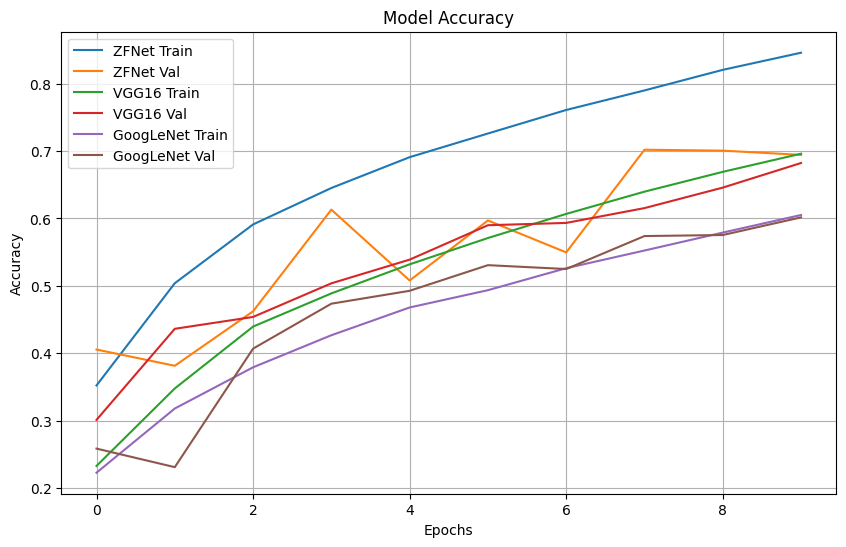

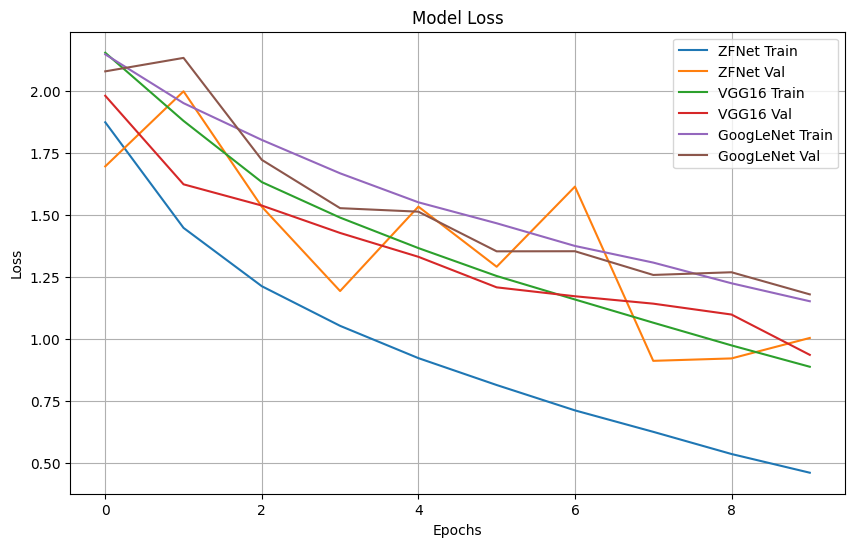

In [5]:
#  STEP 5: Plot Accuracy and Loss

def plot_history(histories, labels, metric):
    plt.figure(figsize=(10, 6))
    for hist, label in zip(histories, labels):
        plt.plot(hist.history[metric], label=f'{label} Train')
        plt.plot(hist.history[f'val_{metric}'], label=f'{label} Val')
    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history([zfnet_history, vgg16_history, googlenet_history], ['ZFNet', 'VGG16', 'GoogLeNet'], 'accuracy')
plot_history([zfnet_history, vgg16_history, googlenet_history], ['ZFNet', 'VGG16', 'GoogLeNet'], 'loss')


In [6]:
#  STEP 6: Final Summary

print("\n Final Accuracy and Inference Time Comparison:")
print(f"ZFNet     - Accuracy: {zfnet_acc:.4f}, Time: {zfnet_time:.2f}s")
print(f"VGG16     - Accuracy: {vgg16_acc:.4f}, Time: {vgg16_time:.2f}s")
print(f"GoogLeNet - Accuracy: {googlenet_acc:.4f}, Time: {googlenet_time:.2f}s")



 Final Accuracy and Inference Time Comparison:
ZFNet     - Accuracy: 0.6942, Time: 801.98s
VGG16     - Accuracy: 0.6821, Time: 3783.12s
GoogLeNet - Accuracy: 0.6015, Time: 874.08s
